# EVIDENCEMR.IPYNB -- Calculate EoS evidence based on M-R observation

In [1]:
### IMPORT STUFF ###

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import multivariate_normal as normal
from ns import ns

G = 6.674e-8 # Newton's constant in cgs units
c = 2.998e10 # speed of light in cm/s
Msun = 1.988e33 # solar mass in g
rhonuc = 2.7e14 # nuclear density in g/cm^3

In [2]:
### PROVIDE OBSERVATIONAL DATA ###

Mobs = 1.34 # SET OBSERVED MASS [Msun] AND ERROR BARS HERE
Merr = 0.01

Robs = 13.9 # SET OBSERVED RADIUS [km] AND ERROR BARS HERE
Rerr = 0.1

def distr(R,M): # 2D Gaussian centered on (Mobs, Robs)
    
    return normal.pdf([R,M],mean=[Robs,Mobs],cov=[[Rerr**2,0],[0,Merr**2]])

def L(R = [],M = []): # Likelihood as a function of (M,R) for plotting purposes
    
    Lmat = np.zeros((len(R),len(M)))
    
    for i in range(len(R)):
        
        for j in range(len(M)):
            
            Lmat[i,j] = distr(R[i],M[j])
    
    return Lmat

In [3]:
### SPECIFY EOS INPUT PARAMETERS ###

eosnames = ["APR4","NL3","MS1B"] # SET EQUATIONS OF STATE HERE
rhocs = np.linspace(1.,5.,10) # SET CENTRAL MASS DENSITIES HERE

eospath = "./" # path to EoS data files
stp = 1e-4 # starting step for numerical integration
pts = 5e3 # number of points at which to evaluate numerical integration
tol = 1e-6 # tolerance for surface finding algorithm

In [4]:
### RUN CODE TO GET M-R RELATIONS ###

Mlist = np.zeros((len(eosnames),len(rhocs)))
Rlist = np.zeros((len(eosnames),len(rhocs)))
rslist = []
muslist = []
mslist = []
lengths = [0]

RM = []

i = 0
for eosname in eosnames:
    j = 0
    print 'Integrating {0}'.format(eosname)
    for rhoc in rhocs:
        [props, rs, mus, ms] = ns(eosname,rhoc,pts,eospath,stp,tol)
        [Rlist[i,j], Mlist[i,j]] = props
        lengths = np.append(lengths,len(rs))
        rslist = np.append(rslist,rs)
        muslist = np.append(muslist,mus)
        mslist = np.append(mslist,ms)

        j = j+1
    
    RMfunc = interp1d(Mlist[i],Rlist[i],kind='linear',bounds_error=False,fill_value=0.)
    RM = np.append(RM,RMfunc)
    i = i+1

Integrating APR4


ns.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  return -(mu+p(mu))*(m+4.*np.pi*r**3*p(mu))/(dpdmu(mu)*r**2*(1.-2.*m/r)) # note that we are using G=c=1 units in this code
ns.py:52: RuntimeWarning: invalid value encountered in double_scalars
  return -(mu+p(mu))*(m+4.*np.pi*r**3*p(mu))/(dpdmu(mu)*r**2*(1.-2.*m/r)) # note that we are using G=c=1 units in this code


Integrating NL3


/opt/anaconda2/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Integrating MS1B


/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


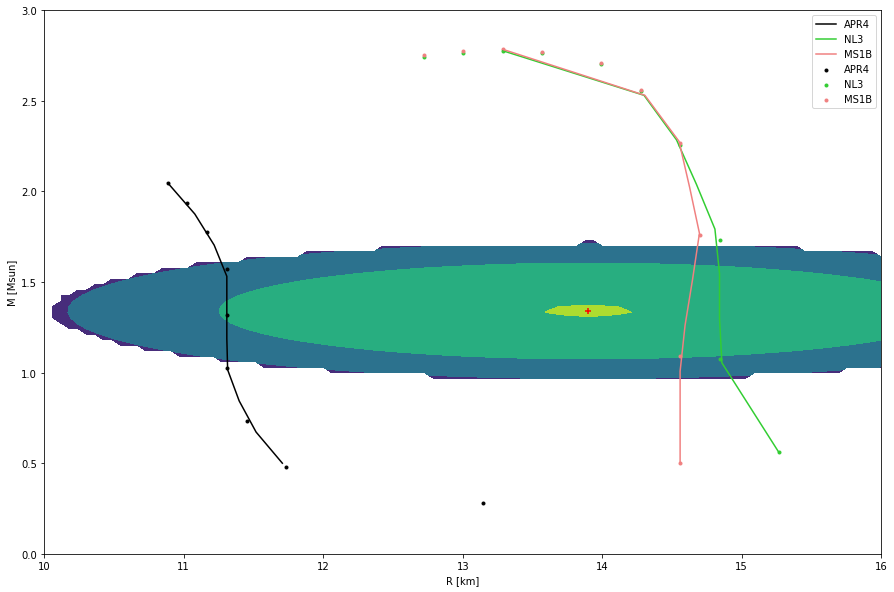

In [5]:
### OUTPUT M-R CURVES AND OBSERVATIONAL LIKELIHOOD ###

colors = ['black','limegreen','lightcoral']

plt.figure(1,(15,10)) # plot interpolated M(R)
MLs = np.linspace(0.,3.0,100)
RLs = np.linspace(10.,16.,100)
plt.contourf(RLs,MLs,np.log10(L(RLs,MLs)).transpose(),2)
plt.scatter(Robs,Mobs,marker='+',c='r')
for i in np.arange(len(eosnames)):
    Ms = np.linspace(max(0.5,min(Mlist[i])),max(Mlist[i]),10)
    plt.scatter(Rlist[i],Mlist[i],c=colors[i],marker='.',label=eosnames[i])
    plt.plot(RM[i](Ms),Ms,c=colors[i],label=eosnames[i])
plt.ylabel('M [Msun]')
plt.xlabel('R [km]')
plt.ylim(0.,3.)
plt.xlim(10.,16.)
plt.legend()

plt.show()


In [6]:
### CALCULATE EVIDENCE FOR EACH EOS ###

evidence0 = lambda M: distr(RM[0](M),M)
evidence1 = lambda M: distr(RM[1](M),M)
evidence2 = lambda M: distr(RM[2](M),M)

e0, err0 = quad(evidence0,0.5,3.)
e1, err1 = quad(evidence1,0.5,3.)
e2, err2 = quad(evidence2,0.5,3.)

print 'The Bayesian evidences for each EoS are E0={0}, E1={1}, E2={2}'.format(e0,e1,e2)
print 'The log evidence ratios (Bayes factors) are B02={0}, B12={1}'.format(np.log10(e0/e2), np.log10(e1/e2))

The Bayesian evidences for each EoS are E0=2.02411491504e-147, E1=6.82627967978e-21, E2=1.97847425571e-12
The log evidence ratios (Bayes factors) are B02=-134.990095238, B12=-8.46214632571
